This notebook aims to check the double descent properties of classes of functions, most notably cos^n(10x)

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.special
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats #used to compute z score and remove outliers
from tqdm import tqdm

In [3]:
def compute_y_from_x_cos(X: np.ndarray):
    return np.add(2.0 * X, np.cos(X * 25))#[:, 0] # y = 2x + cos(25x) Not strongly bunched, infinite inflection points

100%|██████████| 99/99 [14:20<00:00,  8.69s/it]
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated

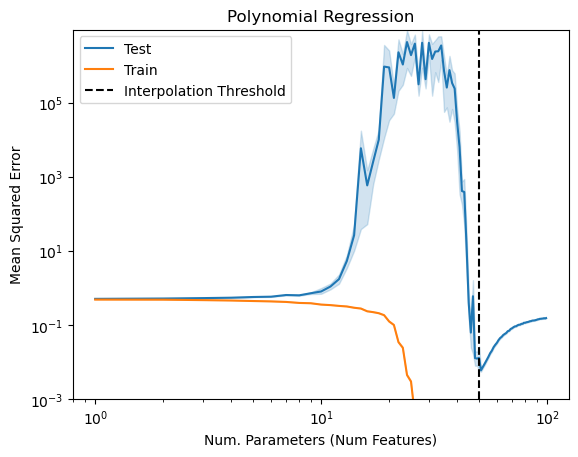

In [6]:
#@title Performing linear fits on computed data, with regularisation and repeats. Does not print out every step.

# Set seed for reproducibility.
np.random.seed(0)

num_data_list = [50]
num_features_list = np.arange(1, 100, 1, dtype=int)
num_repeat_list = list(range(1000))

# Create sklearn linear regression object
regr = linear_model.LinearRegression(fit_intercept=True)


#def compute_y_from_x(X: np.ndarray):
    #return np.add(2.0 * X, np.cos(X * 25))[:, 0] #the function being fit to
    #return np.add(2.0 * X, np.square(np.cos(X*25)))[:, 0] #squared cosine, which seems to dramatically change the character of the behaivour at the interpolation threshold
#    return np.add(2.0 * X, 0.5 * np.power(np.cos(X*25) , 10))[:, 0] #raising cosine to the 10th power to give very spikey function
def compute_y_from_x(X: np.ndarray):
    return compute_y_from_x_cos(X)

low, high = -1.0, 1.0
for num_data in num_data_list:
    mse_list = []
    #results_num_data_dir = os.path.join(results_dir, f"num_data={num_data}")
    #os.makedirs(results_num_data_dir, exist_ok=True)

    # Generate test data.
    X_test = np.linspace(start=low, stop=high, num=1000).reshape(-1, 1)
    y_test = compute_y_from_x(X_test)

    for num_features in tqdm(num_features_list):
        feature_degrees = 1 + np.arange(num_features).astype(int)
        #print(f"feature degrees = ", feature_degrees)
        #print(
        #    f"num_data={num_data}, num_features={num_features}, repeat_idx={repeat_idx}, train_mse={train_mse:.4f}, test_mse={test_mse:.4f}"
        #)
        for repeat_idx in num_repeat_list:
            # Sample training data.
            X_train = np.random.uniform(low=low, high=high, size=(num_data, 1))
            y_train = compute_y_from_x(X_train)

            # Fit a polynomial regression model.
            X_train_poly = scipy.special.eval_legendre(feature_degrees, X_train)
            X_test_poly = scipy.special.eval_legendre(feature_degrees, X_test)
            beta_hat = np.linalg.pinv(X_train_poly) @ y_train
            y_train_pred = X_train_poly @ beta_hat
            y_test_pred = X_test_poly @ beta_hat
            train_mse = mean_squared_error(y_train, y_train_pred)
            test_mse = mean_squared_error(y_test, y_test_pred)
            mse_list.append(
                {
                    "Num. Data": num_data,
                    "Num. Parameters (Num Features)": num_features,
                    "repeat_idx": repeat_idx,
                    "Train MSE": train_mse,
                    "Test MSE": test_mse,
                }
            )
            #print(
            #    f"num_data={num_data}, num_features={num_features}, repeat_idx={repeat_idx}, train_mse={train_mse:.4f}, test_mse={test_mse:.4f}"
            #)

    mse_df = pd.DataFrame(mse_list)
    #mse_df[(np.abs(stats.zscore(mse_df)) < 3).all(axis=1)]
    mse_df = mse_df[(np.abs(stats.zscore(mse_df['Test MSE'])) < 2).to_frame().all(axis=1)] #has more agressive and effective outlier clearing
    plt.close()
    sns.lineplot(
        data=mse_df,
        x="Num. Parameters (Num Features)",
        y="Test MSE",
        label="Test",
    )
    sns.lineplot(
        data=mse_df,
        x="Num. Parameters (Num Features)",
        y="Train MSE",
        label="Train",
    )
    plt.ylabel("Mean Squared Error")
    plt.ylim(bottom=1e-3)
    plt.yscale("log")
    plt.xscale("log")
    plt.title("Polynomial Regression")
    plt.axvline(
        x=num_data, color="black", linestyle="--", label="Interpolation Threshold"
    )
    plt.legend()
    plt.show()


In [ ]:
# Creating plots of many different kinds of function, parameterised by some float

param_list = np.logspace(start=0, stop=2, num=50, base=10, dtype=int) # This stores information about some parameter used to define the function being used

num_data = 50
num_features_list = np.arange(1, 101, 2)
num_repeats = 20

def linear_fitting(function, num_data, num_features_list, num_repeats):
        # Create sklearn linear regression object
    regr = linear_model.LinearRegression(fit_intercept=True)
    def compute_y_from_x(X: np.ndarray):
        return function(X)

    low, high = -1.0, 1.0
    for num_data in num_data_list:
        mse_list = []
        # Generate test data.
        X_test = np.linspace(start=low, stop=high, num=1000).reshape(-1, 1)
        y_test = compute_y_from_x(X_test)

        for num_features in tqdm(num_features_list):
            feature_degrees = 1 + np.arange(num_features).astype(int)
            for repeat_idx in num_repeat_list:
                # Sample training data.
                X_train = np.random.uniform(low=low, high=high, size=(num_data, 1))
                y_train = compute_y_from_x(X_train)

                # Fit a polynomial regression model.
                X_train_poly = scipy.special.eval_legendre(feature_degrees, X_train)
                X_test_poly = scipy.special.eval_legendre(feature_degrees, X_test)
                beta_hat = np.linalg.pinv(X_train_poly) @ y_train
                y_train_pred = X_train_poly @ beta_hat
                y_test_pred = X_test_poly @ beta_hat
                train_mse = mean_squared_error(y_train, y_train_pred)
                test_mse = mean_squared_error(y_test, y_test_pred)
                mse_list.append(
                    {
                        "Num. Data": num_data,
                        "Num. Parameters (Num Features)": num_features,
                        "repeat_idx": repeat_idx,
                        "Train MSE": train_mse,
                        "Test MSE": test_mse,
                    }
                )

        mse_df = pd.DataFrame(mse_list)
        return mse_df
    
def func_compare(param_list, num_data, num_features_list, num_repeats):
    fig, axs = plt.subplots(len(param_list), 1, figsize=(8,5 * len(param_list)), sharey='row') # initialising the figure. Vertically placed
    #fig, axs = plt.subplots(1, len(param_list), sharey='row') # horizonally placed
    for index, param in enumerate(param_list):
        def compute_y_from_x(X: np.ndarray):
            return np.power(np.cos(X * 10), param)
        function = compute_y_from_x
        mse_df = linear_fitting(function, num_data, num_features_list, num_repeats)
        #plt.close()
        # Use the axs object to plot on the specific subplot
        ax = axs[index]
        sns.lineplot(
            data=mse_df,
            x="Num. Parameters (Num Features)",
            y="Test MSE",
            label="Test",
            ax=ax  # specify the subplot
        )
        sns.lineplot(
            data=mse_df,
            x="Num. Parameters (Num Features)",
            y="Train MSE",
            label="Train",
            ax=ax  # specify the subplot
        )
        ax.set_ylabel("Mean Squared Error")
        ax.set_ylim(bottom=1e-3)
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_title(f"Polynomial Regression, cos(10x)^{param}")
        ax.axvline(
            x=num_data, color="black", linestyle="--", label="Interpolation Threshold"
        )
        ax.legend()

    # Adjust the layout of subplots
    plt.tight_layout()

    # Display the figure
    plt.show()
    
func_compare(param_list, num_data, num_features_list, num_repeats)

In [ ]:
# Plotting graphs of the functions being fitted and analysed above

low, high = -1.0, 1.0

for param in param_list:
  def compute_y_from_x(X: np.ndarray):
    return np.power(np.cos(X * 10), param)
  function = compute_y_from_x
  X_test = np.linspace(start=low, stop=high, num=1000).reshape(-1, 1)
  Y_test = function(X_test)
  plt.close()
  plt.xlabel('x')
  plt.xticks(np.arange(-1, 1.5, 0.5))
  plt.ylabel('f(x)', rotation=0)
  #plt.yticks(np.arange(-1, 1.5, 0.5))
  plt.title(f'f(x) = cos(10x)^{param}')
  plt.plot(X_test, Y_test)
  plt.show()